In [1]:
# Import libraries
import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

/home/mgilbertt/Installs/miniconda3/envs/image-search-engine/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

In [3]:
# Define the path to the images folder
image_folder = "archive/flickr30k_images/flickr30k_images"  # replace with the actual path
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(('png', 'jpg', 'jpeg'))]


In [4]:
# Load and preprocess images
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

images = [load_and_preprocess_image(img_path) for img_path in image_paths]

KeyboardInterrupt: 

In [ ]:
# Generate image embeddings
with torch.no_grad():
    inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
    image_embeds = model.get_image_features(**inputs).cpu()
    image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)


IndexError: list index out of range

In [6]:
# Store the embeddings and paths
image_data = {
    "embeddings": image_embeds,
    "paths": image_paths
}

In [7]:
# Optional: Save the embeddings to a file for later use
import pickle
with open("image_embeddings.pkl", "wb") as f:
    pickle.dump(image_data, f)

In [8]:
# Function to preprocess and embed text queries
def embed_text(query):
    with torch.no_grad():
        inputs = processor(text=[query], return_tensors="pt", padding=True).to(device)
        text_embed = model.get_text_features(**inputs).cpu()
        text_embed = text_embed / text_embed.norm(dim=-1, keepdim=True)
    return text_embed

In [9]:
# Example text query
query = "a boy jumping with skateboard"
text_embed = embed_text(query)

In [10]:
# Calculate similarity scores
scores = (text_embed @ image_data["embeddings"].T).squeeze()
scores = scores.numpy()

In [11]:
# Sort and retrieve top N results
N = 5
top_indices = scores.argsort()[-N:][::-1]
top_image_paths = [image_data["paths"][i] for i in top_indices]

In [12]:
for idx in top_indices:
    path = image_data['paths'][idx]
    score = scores[idx]
    print(f"Matched image: {path}, Score: {score:.2f}")


Matched image: images/elephant.jpg, Score: 0.23
Matched image: images/minesweeper.jpeg, Score: 0.22
Matched image: images/profile.jpg, Score: 0.21
Matched image: images/bird.jpg, Score: 0.20
Matched image: images/traffic.jpg, Score: 0.18


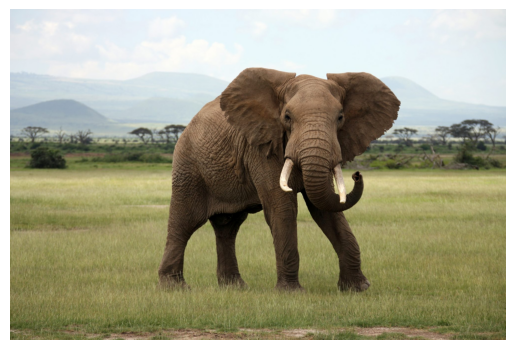

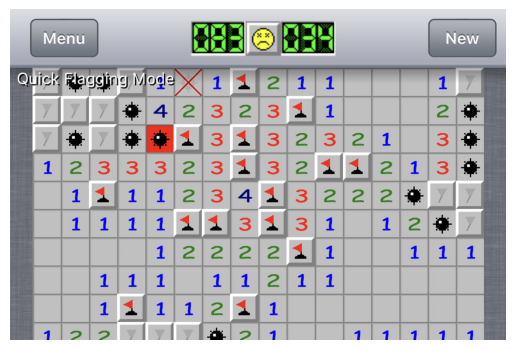

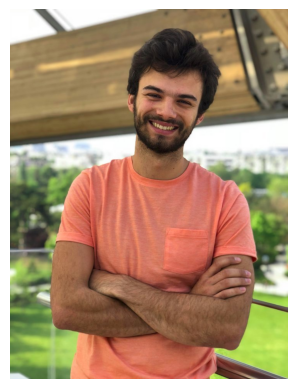

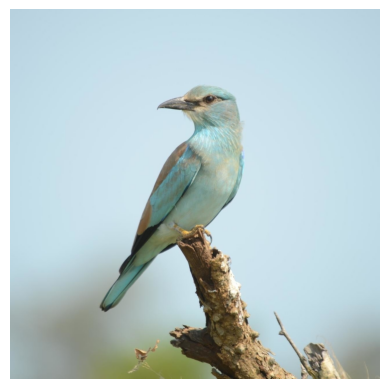

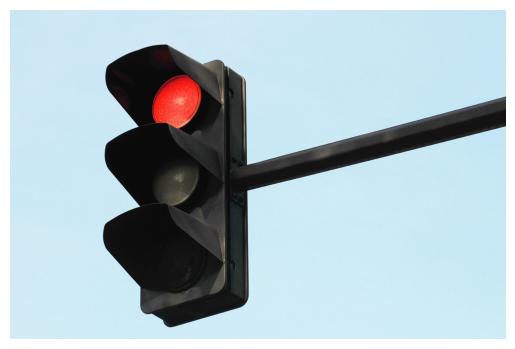

In [13]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(image_paths):
    for img_path in image_paths:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Display the top results
display_images(top_image_paths)
